In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import copy
from collections import namedtuple
import os
import random
import shutil

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR, _LRScheduler


# Load CIFAR10 Dataset

In [2]:
# using pretrained means to normalize the dataset
pretrained_means = [0.4914, 0.4822, 0.4465]
pretrained_stds= [0.247, 0.243, 0.261]
BATCH_SIZE = 128

# define tranforms on the training set
# include resizing and horizontal flip
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = pretrained_means,
                                                     std = pretrained_stds)])
# load the data
train = datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)

# percentage of the training data to be used in training
TRAIN_VAL_RATIO = 0.90

n_train_examples = int(len(train) * TRAIN_VAL_RATIO)
n_valid_examples = len(train) - n_train_examples

train, val = torch.utils.data.random_split(train, [n_train_examples, n_valid_examples])

# applying the transform on validation set
val = copy.deepcopy(val)
val.dataset.transform = transform

# defining appropriate dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Utils Functions

In [3]:
def calculate_accuracy(y_pred, y):
    '''get model accuracy'''
    p = y_pred.argmax(1, keepdim = True)
    acc = p.eq(y.view_as(p)).sum().float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    '''
    function to be called for training and collect 
    model loss and model accuracy
    and perform a training step

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # set to training mode
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        # update loss and accuracy values
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    '''
    function to be called for evaluating and collect 
    model val loss and model val accuracy

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # evaluation mode
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [4]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        self.model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        #y_pred, _ = self.model(x) original
        y_pred = self.model(x)

                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [5]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

In [6]:
def get_preds(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [7]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

In [8]:
def labels_accuracy(y, y_pred):
    crr = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            crr += 1
    return crr/len(y)

In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [10]:
def show_incorrect_preds(incorrect, classes, n_images, normalize = False):

    rows = 1 
    cols = n_images  

    fig = plt.figure(figsize = (10, 10))
    fig.tight_layout()
    for i in range(cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image[0]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label][0]
        incorrect_class = classes[incorrect_label][0]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true class: {true_class}\n' \
                     f'pred class: {incorrect_class}')
        ax.axis('off')


# VGG

In [11]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        
        self.features = features
        
        #self.avgpool = nn.AdaptiveAvgPool2d(7)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 , 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x#, h

In [12]:
def get_vgg_layers(config, batch_norm):
    
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers)

In [13]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

In [14]:
vgg13_layers = get_vgg_layers(vgg13_config, batch_norm = True)
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm = True)
vgg19_layers = get_vgg_layers(vgg19_config, batch_norm = True)

#vgg16_layers

## VGG16

In [15]:
OUTPUT_DIM = 10

#model_VGG13 = VGG(vgg13_layers, OUTPUT_DIM)
model_VGG16 = VGG(vgg16_layers, OUTPUT_DIM)
#model_VGG19 = VGG(vgg19_layers, OUTPUT_DIM)

#print(model_VGG16)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_VGG16 = model_VGG16.to(device)

In [17]:
from torchsummary import summary

#summary(model_VGG16.to(device), (3, 32, 32))

### Find best LR

In [18]:
START_LR = 1e-7

optimizer = optim.SGD(model_VGG16.parameters(), momentum=0.9, lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model_VGG16 = model_VGG16.to(device)
criterion = criterion.to(device)

In [19]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model_VGG16, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

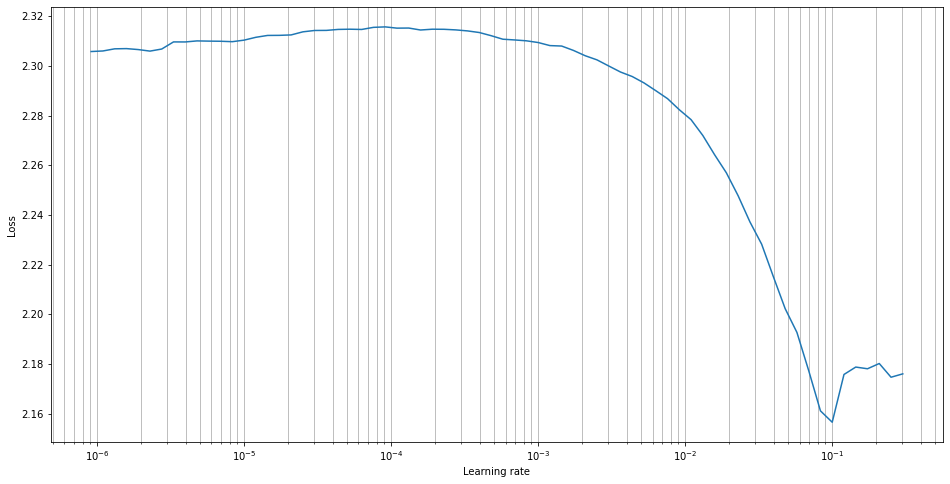

In [20]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

### Training

In [21]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.SGD(model_VGG16.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0001)

# scheduler for VGG
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10], last_epoch= -1)


In [22]:
EPOCHS = 50
train_loss_list_VGG16 = []
train_acc_list_VGG16 = []

val_loss_list_VGG16 = []
val_acc_list_VGG16 = []

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model_VGG16, train_loader, optimizer, criterion, device)
    scheduler.step()
    val_loss, val_acc = evaluate(model_VGG16, val_loader, criterion, device)
    end_time = time.time()

    train_loss_list_VGG16.append(train_loss)
    train_acc_list_VGG16.append(train_acc)
    val_loss_list_VGG16.append(val_loss)
    val_acc_list_VGG16.append(val_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    ct = datetime.datetime.now()
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s, | Timestamp: {ct}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    


Epoch: 01 | Epoch Time: 0m 34s, | Timestamp: 2021-05-14 22:51:12.785304
	Train Loss: 1.385 | Train Acc: 49.25%
	 Val. Loss: 1.128 |  Val. Acc: 60.16%
Epoch: 02 | Epoch Time: 0m 34s, | Timestamp: 2021-05-14 22:51:47.446913
	Train Loss: 0.880 | Train Acc: 69.86%
	 Val. Loss: 0.828 |  Val. Acc: 71.76%
Epoch: 03 | Epoch Time: 0m 34s, | Timestamp: 2021-05-14 22:52:22.237244
	Train Loss: 0.691 | Train Acc: 76.88%
	 Val. Loss: 0.720 |  Val. Acc: 76.37%
Epoch: 04 | Epoch Time: 0m 34s, | Timestamp: 2021-05-14 22:52:57.044839
	Train Loss: 0.577 | Train Acc: 80.84%
	 Val. Loss: 0.657 |  Val. Acc: 77.21%
Epoch: 05 | Epoch Time: 0m 35s, | Timestamp: 2021-05-14 22:53:32.051691
	Train Loss: 0.491 | Train Acc: 83.80%
	 Val. Loss: 0.681 |  Val. Acc: 78.11%
Epoch: 06 | Epoch Time: 0m 35s, | Timestamp: 2021-05-14 22:54:07.208017
	Train Loss: 0.428 | Train Acc: 86.01%
	 Val. Loss: 0.516 |  Val. Acc: 83.28%
Epoch: 07 | Epoch Time: 0m 35s, | Timestamp: 2021-05-14 22:54:42.292232
	Train Loss: 0.378 | Train A

In [23]:
images, labels, probs = get_preds(model_VGG16, test_loader)
pred_labels = torch.argmax(probs, 1)

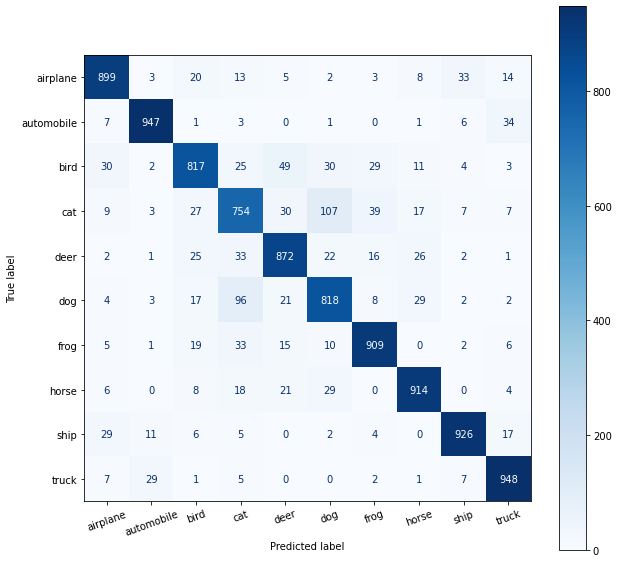

In [24]:
classes = test.classes

plot_confusion_matrix(labels, pred_labels, classes)

Text(0.5, 1.0, 'VGG16 , Cross Entropy Loss across Epochs')

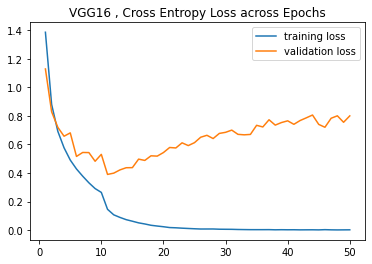

In [25]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_loss_list_VGG16, label = 'training loss')
plt.plot([i for i in range(1,EPOCHS + 1)], val_loss_list_VGG16, label = 'validation loss')
plt.legend()
plt.title('VGG16 , Cross Entropy Loss across Epochs')

Text(0.5, 1.0, 'VGG16 , Accuracy across Epochs')

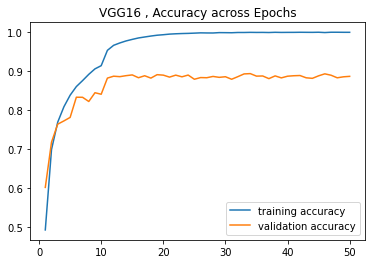

In [26]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_acc_list_VGG16, label = 'training accuracy')
plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list_VGG16, label = 'validation accuracy')
plt.legend()
plt.title('VGG16 , Accuracy across Epochs')

In [27]:
labels_accuracy(labels.numpy(), pred_labels.numpy())

0.8804

In [28]:
correct_pred = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, correct_pred):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

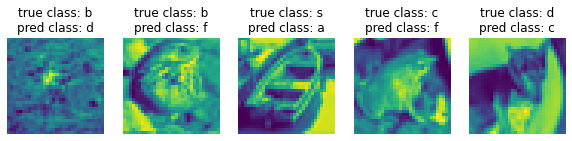

In [29]:
show_incorrect_preds(incorrect_examples, classes, 5)

## VGG13

In [30]:
OUTPUT_DIM = 10

model_VGG13 = VGG(vgg13_layers, OUTPUT_DIM)
#model_VGG16 = VGG(vgg16_layers, OUTPUT_DIM)
#model_VGG19 = VGG(vgg19_layers, OUTPUT_DIM)

#print(model_VGG16)

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_VGG16 = model_VGG16.to(device)

In [32]:
from torchsummary import summary

#summary(model_VGG13.to(device), (3, 32, 32))

### Find Best LR

In [33]:
START_LR = 1e-7

optimizer = optim.SGD(model_VGG13.parameters(), momentum=0.9, lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model_VGG13 = model_VGG13.to(device)
criterion = criterion.to(device)

In [34]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model_VGG13, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

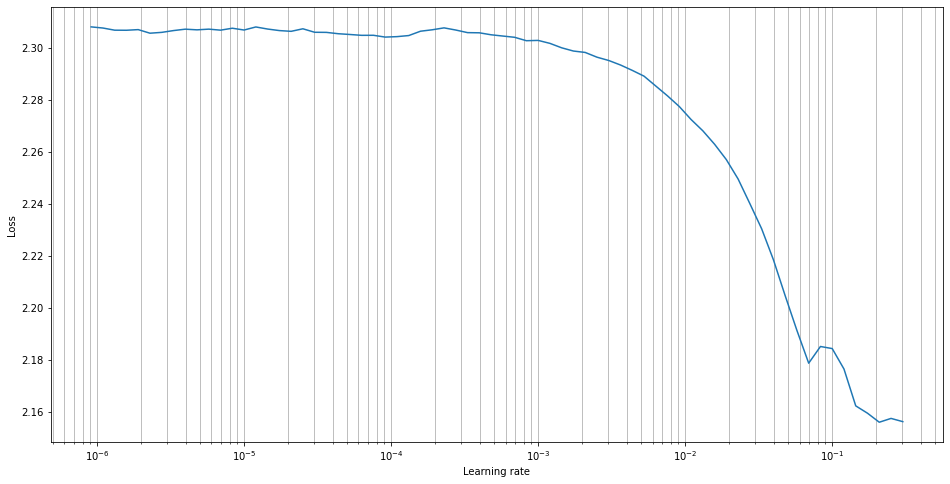

In [35]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

### Training

In [36]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.SGD(model_VGG13.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0001)

# scheduler for VGG
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10], last_epoch= -1)

In [37]:
EPOCHS = 50
train_loss_list_VGG13 = []
train_acc_list_VGG13 = []

val_loss_list_VGG13 = []
val_acc_list_VGG13 = []

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model_VGG13, train_loader, optimizer, criterion, device)
    scheduler.step()
    val_loss, val_acc = evaluate(model_VGG13, val_loader, criterion, device)
    end_time = time.time()

    train_loss_list_VGG13.append(train_loss)
    train_acc_list_VGG13.append(train_acc)
    val_loss_list_VGG13.append(val_loss)
    val_acc_list_VGG13.append(val_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    ct = datetime.datetime.now()
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s, | Timestamp: {ct}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    


Epoch: 01 | Epoch Time: 0m 30s, | Timestamp: 2021-05-14 23:20:35.805289
	Train Loss: 1.330 | Train Acc: 51.54%
	 Val. Loss: 1.375 |  Val. Acc: 54.84%
Epoch: 02 | Epoch Time: 0m 30s, | Timestamp: 2021-05-14 23:21:06.774436
	Train Loss: 0.848 | Train Acc: 70.48%
	 Val. Loss: 0.865 |  Val. Acc: 70.96%
Epoch: 03 | Epoch Time: 0m 30s, | Timestamp: 2021-05-14 23:21:37.577677
	Train Loss: 0.656 | Train Acc: 77.81%
	 Val. Loss: 0.649 |  Val. Acc: 77.97%
Epoch: 04 | Epoch Time: 0m 30s, | Timestamp: 2021-05-14 23:22:08.408605
	Train Loss: 0.540 | Train Acc: 81.77%
	 Val. Loss: 0.591 |  Val. Acc: 80.14%
Epoch: 05 | Epoch Time: 0m 30s, | Timestamp: 2021-05-14 23:22:39.302729
	Train Loss: 0.465 | Train Acc: 84.44%
	 Val. Loss: 0.607 |  Val. Acc: 79.36%
Epoch: 06 | Epoch Time: 0m 30s, | Timestamp: 2021-05-14 23:23:10.180782
	Train Loss: 0.403 | Train Acc: 86.71%
	 Val. Loss: 0.591 |  Val. Acc: 81.11%
Epoch: 07 | Epoch Time: 0m 30s, | Timestamp: 2021-05-14 23:23:41.148793
	Train Loss: 0.349 | Train A

In [38]:
images, labels, probs = get_preds(model_VGG13, test_loader)
pred_labels = torch.argmax(probs, 1)

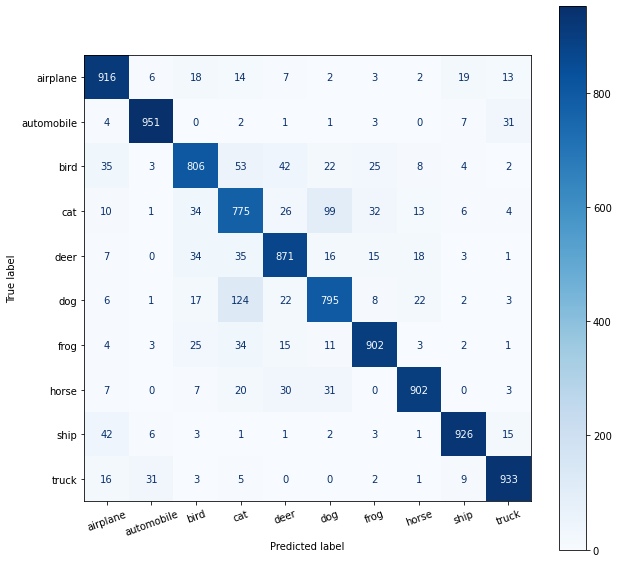

In [39]:
classes = test.classes

plot_confusion_matrix(labels, pred_labels, classes)

Text(0.5, 1.0, 'VGG13 , Cross Entropy Loss across Epochs')

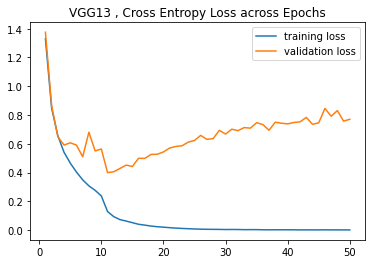

In [40]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_loss_list_VGG13, label = 'training loss')
plt.plot([i for i in range(1,EPOCHS + 1)], val_loss_list_VGG13, label = 'validation loss')
plt.legend()
plt.title('VGG13 , Cross Entropy Loss across Epochs')

Text(0.5, 1.0, 'VGG13 , Accuracy across Epochs')

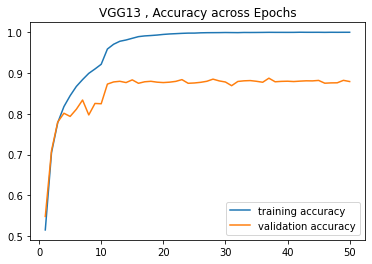

In [41]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_acc_list_VGG13, label = 'training accuracy')
plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list_VGG13, label = 'validation accuracy')
plt.legend()
plt.title('VGG13 , Accuracy across Epochs')

In [42]:
labels_accuracy(labels.numpy(), pred_labels.numpy())

0.8777

In [43]:
correct_pred = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, correct_pred):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

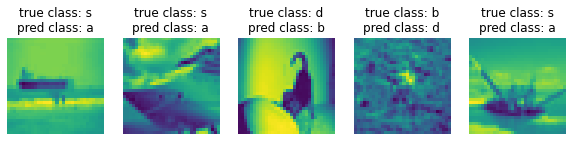

In [44]:
show_incorrect_preds(incorrect_examples, classes, 5)

# Resnet

In [45]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x#, h

In [46]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [47]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [48]:
class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, channels = config
        self.in_channels = channels[0]
            
        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x#, h

In [49]:
class Identity(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)
        

class CIFARBasicBlock(nn.Module):
        
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
                
        
        if downsample:
            identity_fn = lambda x : F.pad(x[:, :, ::2, ::2], [0, 0, 0, 0, in_channels // 2, in_channels // 2])
            downsample = Identity(identity_fn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                                
        x += i
        x = self.relu(x)
        
        return x

In [50]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [51]:
resnet18_config = ResNetConfig (block = BasicBlock, n_blocks = [2,2,2,2], channels = [64, 128, 256, 512])
resnet34_config = ResNetConfig (block = BasicBlock, n_blocks = [3,4,6,3], channels = [64, 128, 256, 512])

resnet50_config = ResNetConfig (block = Bottleneck,n_blocks = [3, 4, 6, 3], channels = [64, 128, 256, 512])

cifar_resnet20_config = ResNetConfig (block = CIFARBasicBlock, n_blocks = [3, 3, 3], channels = [16, 32, 64])
cifar_resnet32_config = ResNetConfig (block = CIFARBasicBlock, n_blocks = [5, 5, 5], channels = [16, 32, 64])
cifar_resnet44_config = ResNetConfig (block = CIFARBasicBlock, n_blocks = [7, 7, 7], channels = [16, 32, 64])

## Resnet44

In [52]:
#model_Resnet20 = CIFARResNet(cifar_resnet20_config,10)
model_Resnet44 = CIFARResNet(cifar_resnet44_config,10)

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_Resnet44 = model_Resnet44.to(device)
#model_Resnet44

In [54]:
from torchsummary import summary

#summary(model_Resnet44.to(device), (3, 32, 32))

### Find Best LR

In [55]:
START_LR = 1e-7

optimizer = optim.SGD(model_Resnet44.parameters(), momentum=0.9, lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model_Resnet44 = model_Resnet44.to(device)
criterion = criterion.to(device)

In [56]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model_Resnet44, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

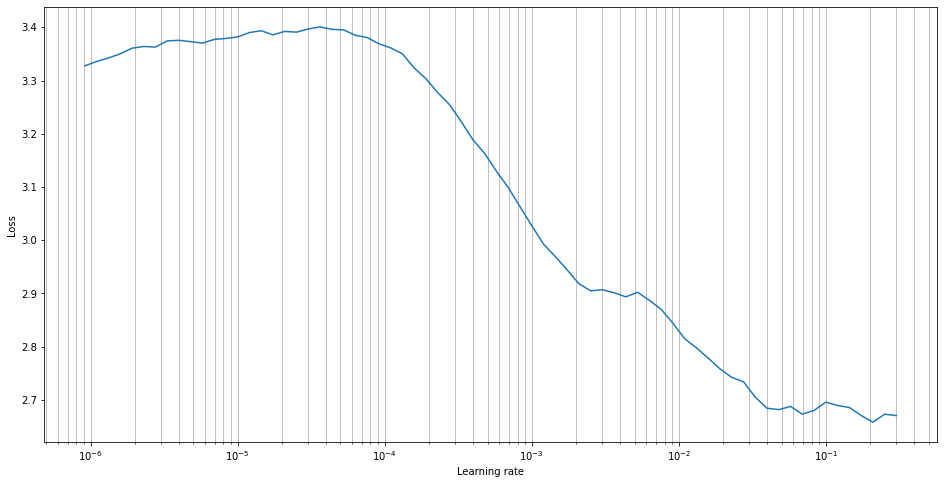

In [57]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

###  Training

In [58]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.SGD(model_Resnet44.parameters(), momentum=0.1, lr = 0.01, weight_decay=0.0001)

# scheduler for ResNet
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[100, 150], last_epoch= -1)

In [59]:
EPOCHS = 50
train_loss_list_Resnet44 = []
train_acc_list_Resnet44 = []

val_loss_list_Resnet44 = []
val_acc_list_Resnet44 = []

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model_Resnet44, train_loader, optimizer, criterion, device)
    scheduler.step()
    val_loss, val_acc = evaluate(model_Resnet44, val_loader, criterion, device)
    end_time = time.time()

    train_loss_list_Resnet44.append(train_loss)
    train_acc_list_Resnet44.append(train_acc)
    val_loss_list_Resnet44.append(val_loss)
    val_acc_list_Resnet44.append(val_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    ct = datetime.datetime.now()
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s, | Timestamp: {ct}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    


Epoch: 01 | Epoch Time: 0m 36s, | Timestamp: 2021-05-14 23:46:34.683535
	Train Loss: 1.632 | Train Acc: 39.24%
	 Val. Loss: 1.561 |  Val. Acc: 45.12%
Epoch: 02 | Epoch Time: 0m 36s, | Timestamp: 2021-05-14 23:47:10.975829
	Train Loss: 1.272 | Train Acc: 53.60%
	 Val. Loss: 1.399 |  Val. Acc: 50.41%
Epoch: 03 | Epoch Time: 0m 36s, | Timestamp: 2021-05-14 23:47:47.224167
	Train Loss: 1.091 | Train Acc: 60.75%
	 Val. Loss: 1.510 |  Val. Acc: 50.74%
Epoch: 04 | Epoch Time: 0m 36s, | Timestamp: 2021-05-14 23:48:23.529842
	Train Loss: 0.964 | Train Acc: 65.37%
	 Val. Loss: 1.066 |  Val. Acc: 62.91%
Epoch: 05 | Epoch Time: 0m 36s, | Timestamp: 2021-05-14 23:48:59.786448
	Train Loss: 0.870 | Train Acc: 68.94%
	 Val. Loss: 1.014 |  Val. Acc: 64.16%
Epoch: 06 | Epoch Time: 0m 36s, | Timestamp: 2021-05-14 23:49:36.070294
	Train Loss: 0.793 | Train Acc: 71.85%
	 Val. Loss: 0.917 |  Val. Acc: 68.61%
Epoch: 07 | Epoch Time: 0m 36s, | Timestamp: 2021-05-14 23:50:12.089511
	Train Loss: 0.737 | Train A

In [60]:
images, labels, probs = get_preds(model_Resnet44, test_loader)
pred_labels = torch.argmax(probs, 1)

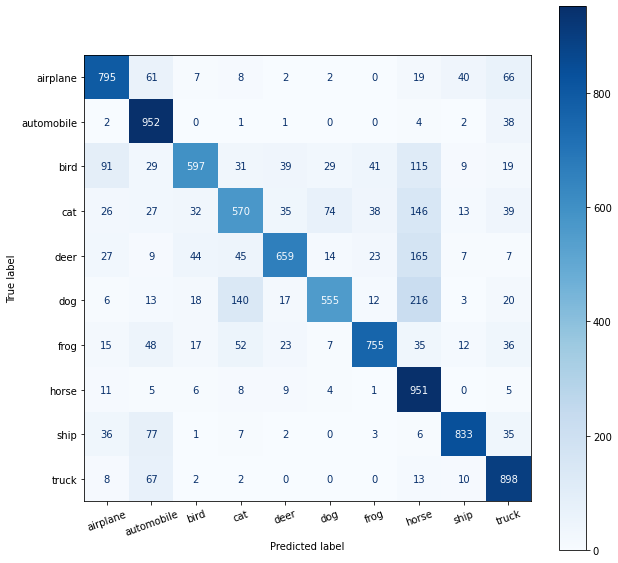

In [61]:
classes = test.classes

plot_confusion_matrix(labels, pred_labels, classes)

Text(0.5, 1.0, 'Resnet44 , Cross Entropy Loss across Epochs')

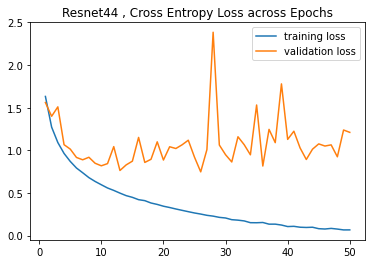

In [62]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_loss_list_Resnet44, label = 'training loss')
plt.plot([i for i in range(1,EPOCHS + 1)], val_loss_list_Resnet44, label = 'validation loss')
plt.legend()
plt.title('Resnet44 , Cross Entropy Loss across Epochs')

Text(0.5, 1.0, 'Resnet44 , Accuracy across Epochs')

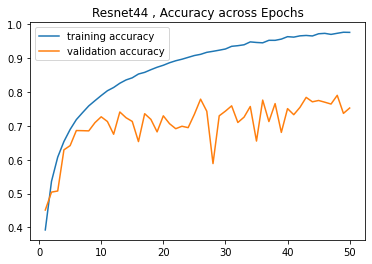

In [63]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_acc_list_Resnet44, label = 'training accuracy')
plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list_Resnet44, label = 'validation accuracy')
plt.legend()
plt.title('Resnet44 , Accuracy across Epochs')

In [64]:
labels_accuracy(labels.numpy(), pred_labels.numpy())

0.7565

In [65]:
correct_pred = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, correct_pred):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

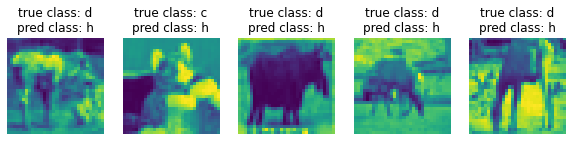

In [66]:
show_incorrect_preds(incorrect_examples, classes, 5)

## Resnet20

In [67]:
model_Resnet20 = CIFARResNet(cifar_resnet20_config,10)
#model_Resnet44 = CIFARResNet(cifar_resnet44_config,10)

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_Resnet20 = model_Resnet20.to(device)
#model_Resnet44

In [69]:
from torchsummary import summary

#summary(model_Resnet20.to(device), (3, 32, 32))

### Find Best LR

In [70]:
START_LR = 1e-7

optimizer = optim.SGD(model_Resnet20.parameters(), momentum=0.9, lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model_Resnet20 = model_Resnet20.to(device)
criterion = criterion.to(device)

In [71]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model_Resnet20, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

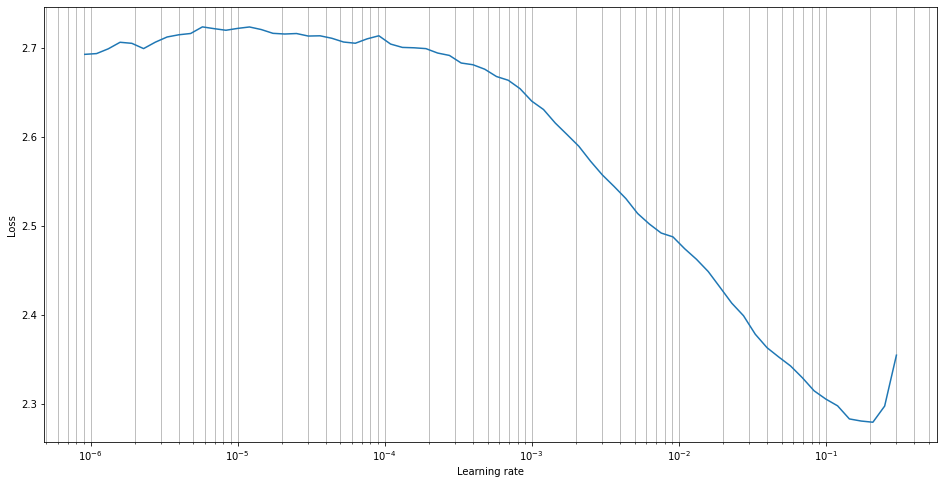

In [72]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

### Training

In [73]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.SGD(model_Resnet20.parameters(), momentum=0.1, lr = 0.01, weight_decay=0.0001)
 
# scheduler for ResNet
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[100, 150], last_epoch= -1)

In [74]:
EPOCHS = 50
train_loss_list_Resnet20 = []
train_acc_list_Resnet20 = []

val_loss_list_Resnet20 = []
val_acc_list_Resnet20 = []

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model_Resnet20, train_loader, optimizer, criterion, device)
    scheduler.step()
    val_loss, val_acc = evaluate(model_Resnet20, val_loader, criterion, device)
    end_time = time.time()

    train_loss_list_Resnet20.append(train_loss)
    train_acc_list_Resnet20.append(train_acc)
    val_loss_list_Resnet20.append(val_loss)
    val_acc_list_Resnet20.append(val_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    ct = datetime.datetime.now()
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s, | Timestamp: {ct}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    


Epoch: 01 | Epoch Time: 0m 21s, | Timestamp: 2021-05-15 00:16:37.173852
	Train Loss: 1.697 | Train Acc: 37.16%
	 Val. Loss: 1.794 |  Val. Acc: 38.01%
Epoch: 02 | Epoch Time: 0m 21s, | Timestamp: 2021-05-15 00:16:58.263048
	Train Loss: 1.350 | Train Acc: 50.73%
	 Val. Loss: 1.389 |  Val. Acc: 47.48%
Epoch: 03 | Epoch Time: 0m 21s, | Timestamp: 2021-05-15 00:17:19.345709
	Train Loss: 1.179 | Train Acc: 57.18%
	 Val. Loss: 1.343 |  Val. Acc: 52.05%
Epoch: 04 | Epoch Time: 0m 21s, | Timestamp: 2021-05-15 00:17:40.362320
	Train Loss: 1.058 | Train Acc: 62.02%
	 Val. Loss: 1.163 |  Val. Acc: 58.09%
Epoch: 05 | Epoch Time: 0m 20s, | Timestamp: 2021-05-15 00:18:01.347727
	Train Loss: 0.978 | Train Acc: 64.69%
	 Val. Loss: 1.143 |  Val. Acc: 58.87%
Epoch: 06 | Epoch Time: 0m 21s, | Timestamp: 2021-05-15 00:18:22.416899
	Train Loss: 0.909 | Train Acc: 67.43%
	 Val. Loss: 1.000 |  Val. Acc: 64.57%
Epoch: 07 | Epoch Time: 0m 20s, | Timestamp: 2021-05-15 00:18:43.376376
	Train Loss: 0.857 | Train A

In [75]:
images, labels, probs = get_preds(model_Resnet20, test_loader)
pred_labels = torch.argmax(probs, 1)

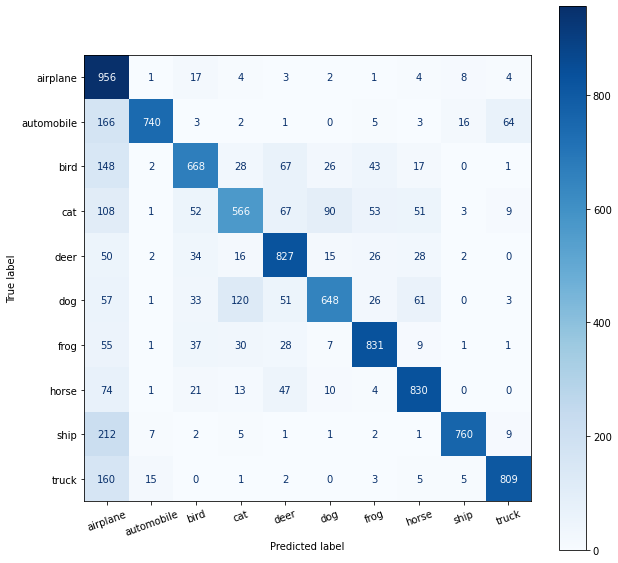

In [76]:
classes = test.classes

plot_confusion_matrix(labels, pred_labels, classes)

Text(0.5, 1.0, 'Resnet20 , Cross Entropy Loss across Epochs')

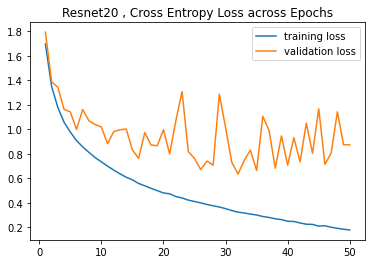

In [77]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_loss_list_Resnet20, label = 'training loss')
plt.plot([i for i in range(1,EPOCHS + 1)], val_loss_list_Resnet20, label = 'validation loss')
plt.legend()
plt.title('Resnet20 , Cross Entropy Loss across Epochs')

Text(0.5, 1.0, 'Resnet20 , Accuracy across Epochs')

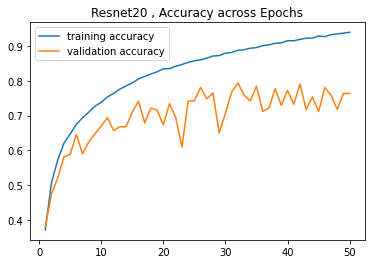

In [78]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_acc_list_Resnet20, label = 'training accuracy')
plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list_Resnet20, label = 'validation accuracy')
plt.legend()
plt.title('Resnet20 , Accuracy across Epochs')

In [79]:
labels_accuracy(labels.numpy(), pred_labels.numpy())

0.7635

In [80]:
correct_pred = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, correct_pred):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

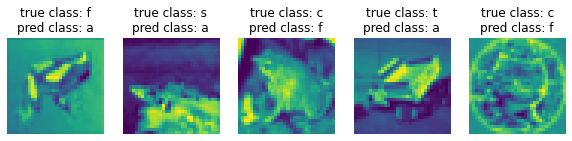

In [81]:
show_incorrect_preds(incorrect_examples, classes, 5)

# Comparing Models

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


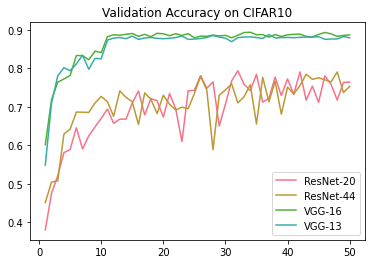

In [82]:
import seaborn as sns
with sns.color_palette("husl"):
  
    #sns.lineplot([i for i in range(1,EPOCHS + 1)], train_acc_list, label = 'Training Accuracy')
    sns.lineplot([i for i in range(1,EPOCHS + 1)], val_acc_list_Resnet20, label = 'ResNet-20')
    plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list_Resnet44, label = 'ResNet-44')
    plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list_VGG16, label = 'VGG-16')
    plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list_VGG13, label = 'VGG-13')
    plt.legend()
    plt.title('Validation Accuracy on CIFAR10')